<a href="https://colab.research.google.com/github/NSR9/PythonForML-AI-Notes/blob/master/S6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

In [0]:
# simple function to upload files from local drive

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

**Data Transformations**


* Here I've created a Class to transform Train & Test Data. And I'm using Compose function to chain in all the transform operations required in the form of list and then pass it on the different sets of data.
* I have already set the mean and the standard deviation to 0.1307 & 0.3081 
* 2 main parameters normalize(boolean) and rotate(default value = 0).


In [0]:
# # Transformations 

# class Transformations():

#   def __init__(self, normalize=True, rotate = 0):
#       self.normalize = normalize
#       self.rotate = rotate


#   # For Train Data
#   def train_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = []
#       transforms_list.append(transforms.ToTensor())
#       if self.normalize: 
#           transforms_list.append(transforms.Normalize((0.1307, ), (0.3081, )))
#       if self.rotate:
#           transforms_list.append(transforms.RandomRotation((-1*int(self.rotate), int(self.rotate)), fill=(1,)))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)


#   # For Test Data
#   def test_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = [transforms.ToTensor()]
#       if self.normalize:
#           transforms_list.append(transforms.Normalize((0.1307, ),(0.3081, )))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)



# mnist_data = Transformations(normalize = True, rotate = 5)    # set normalize = True
# train_trans = mnist_data.train_transforms(tensorToPIL = True)  # Rotation of Train Images
# test_trans = mnist_data.test_transforms(tensorToPIL = True)

In [0]:
# Transformations

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                      #  transforms.ToPILImage()# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      #  transforms.ToPILImage()
                                       ])


In [0]:
# Split Test & Train Data
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

**Dataloaders Arguments & Train/Test Dataloaders**

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 128):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

**Data Statistics**

torch.Size([128, 1, 28, 28])
torch.Size([128])


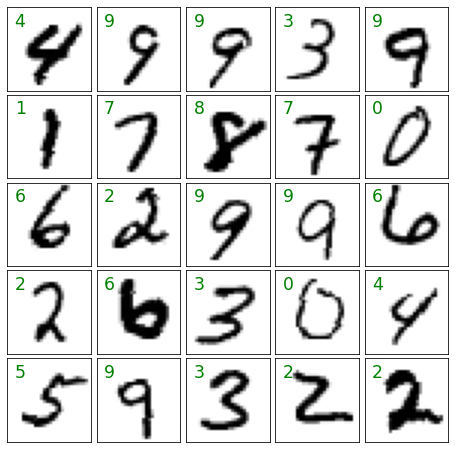

In [5]:

data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape) # [64, 1, 28, 28]
print(labels.shape) # [64]


from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline


def display_25(images, labels):
  figmatrix = plt.figure(figsize=(8, 8))
  row, col = 5, 5 # set rows & columns = 5
  gs = gridspec.GridSpec(row, col)
  gs.update(wspace=0.005, hspace=0.05)

  for i in range(1, 26):
    plt.subplot(gs[i-1])
    plt.tick_params( axis='both', which='both', labelbottom=False, labelleft=False, left=False, bottom=False)
    plt.imshow(images[i-1].numpy().squeeze(), cmap='gray_r')
    plt.text(2, 6, labels[i-1].numpy(), color="green", fontsize="xx-large")
  plt.show()

display_25(images[:25], labels[:25])



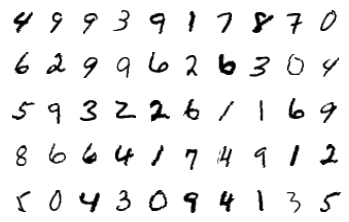

In [6]:
# Just curious at the orientation of these mnist images
figure = plt.figure()
num_of_images = 50
for i in range(1,num_of_images+1):
  plt.subplot(5,10, i)
  plt.axis('off')
  plt.imshow(images[i-1].numpy().squeeze(), cmap = 'gray_r')

In [0]:
# Main Model with Batch Normalization
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          nn.BatchNorm2d(8)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
          # nn.ReLU(),
          # nn.BatchNorm2d(16)) # O/P: 4


    # # ConvBlock 7
    #   self.convblock7 = nn.Sequential(
    #       nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False))
          # nn.ReLU(),
          # nn.BatchNorm2d(16)) # O/P: 4


    # # ConvBlock 8
    #   self.convblock8 = nn.Sequential(
    #       nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
    #       nn.ReLU(),
    #       nn.BatchNorm2d(16)) # O/P: 6
    

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      # x = self.drop(x)
      x = self.convblock6(x)
      # x = self.drop(x)
      # x = self.convblock7(x)
      # x = self.convblock8(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      



In [8]:
# BN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss


      # # Implementing l2 Regularization
      # if L2lambda:
      #   with torch.enable_grad():
      #     l2_loss = 0
      #     for name, param in model.named_parameters():
      #         l2_loss = l2_loss + (0.5 * l2_loss * torch.sum(torch.pow(W, 2)))
      #     loss = loss + L2Lambda * l2_loss


      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))

    




**Model 1**
#without L1 and L2 regularization with BN


In [0]:
from torch.optim.lr_scheduler import OneCycleLR


def withoutL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  #scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with BN')
#without L1 and L2 regularization with BN

  model1= Test_Train()
  global loss1
  # global acc1
  loss1 = model1.test_losses
  global acc1
  acc1 = model1.test_acc

  EPOCHS = 25  
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model1.train(model, device, train_loader, optimizer, epoch, scheduler)
      model1.test(model, device, test_loader,"model1.pt")



**Model 2**
#with L1 regularization with BN


In [0]:
from torch.optim.lr_scheduler import OneCycleLR

def withL1_BN():
  model =  Net().to(device)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#second model
  print('with L1 regularization with BN')
#with L1 regularization with BN
  model2 = Test_Train()
  global loss2
  # global acc2
  loss2 = model2.test_losses
  global acc2 
  acc2 = model2.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model2.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model2.test(model, device, test_loader,"model2.pt")

**Model 3**
#with L2 regularization with BN


In [0]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR

def withL2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#third model
  print('with L2 regularization with BN')
#with L2 regularization 
  model3 = Test_Train()
  global loss3
  # global acc3
  loss3 = model3.test_losses
  global acc3 
  acc3 = model3.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model3.train(model, device, train_loader, optimizer, epoch, scheduler)
      model3.test(model, device, test_loader,"model3.pt")

**Model 4**
#with both L1 & L2 regularization with BN


In [0]:
# model =  Net().to(device)


def withL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#fourth  model
  print('with L1 & L2 regularization with BN')
#with both L1 & L2 regularization with BN
  model4 = Test_Train()
  global loss4
  # global acc4
  loss4 = model4.test_losses
  global acc4 
  acc4 = model4.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model4.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model4.test(model, device, test_loader,"model4.pt")

In [14]:
modelTuple = iter(withoutL1_L2_BN(),
  withL1_BN())

print(modelTuple.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

without L1 and L2 regularization with BN
EPOCH: 1


Loss=0.02292191982269287 Batch_id=468 Accuracy=87.46: 100%|██████████| 469/469 [00:52<00:00,  9.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0709).  Saving model ...

Test set: Average loss: 0.0709, Accuracy: 9772/10000 (97.72%)

EPOCH: 2


Loss=0.07932262867689133 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:52<00:00,  9.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0709 --> 0.0451).  Saving model ...

Test set: Average loss: 0.0451, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.05168589949607849 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:52<00:00,  8.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0451 --> 0.0436).  Saving model ...

Test set: Average loss: 0.0436, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.02007904462516308 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:52<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0436 --> 0.0298).  Saving model ...

Test set: Average loss: 0.0298, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.001288534956984222 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0298 --> 0.0298).  Saving model ...

Test set: Average loss: 0.0298, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.011276359669864178 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9896/10000 (98.96%)

EPOCH: 7


Loss=0.037323959171772 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:52<00:00,  9.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0298 --> 0.0279).  Saving model ...

Test set: Average loss: 0.0279, Accuracy: 9907/10000 (99.07%)

EPOCH: 8


Loss=0.0032015491742640734 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:51<00:00,  9.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0279 --> 0.0215).  Saving model ...

Test set: Average loss: 0.0215, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.03302786126732826 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:52<00:00,  9.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.0581214465200901 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.024595750495791435 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:51<00:00,  9.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.02815067023038864 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.014604606665670872 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:51<00:00,  9.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.004627669230103493 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:51<00:00,  9.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.002266311552375555 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:51<00:00,  9.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0215 --> 0.0203).  Saving model ...

Test set: Average loss: 0.0203, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.004912571515887976 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:52<00:00,  9.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.0019574170000851154 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0203 --> 0.0193).  Saving model ...

Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.005469253286719322 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:51<00:00,  9.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0193 --> 0.0193).  Saving model ...

Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.0564921610057354 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0193 --> 0.0183).  Saving model ...

Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.001523698098026216 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:51<00:00,  9.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0183 --> 0.0171).  Saving model ...

Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

EPOCH: 21


Loss=0.0034366787876933813 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:51<00:00,  9.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.023390255868434906 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9950/10000 (99.50%)

EPOCH: 23


Loss=0.006271774414926767 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:51<00:00,  9.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0171 --> 0.0166).  Saving model ...

Test set: Average loss: 0.0166, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


Loss=0.0010362964821979403 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:51<00:00,  9.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0166 --> 0.0163).  Saving model ...

Test set: Average loss: 0.0163, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


Loss=0.10043749958276749 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9948/10000 (99.48%)

with L1 regularization with BN
EPOCH: 1


Loss=0.12125478684902191 Batch_id=468 Accuracy=87.83: 100%|██████████| 469/469 [00:52<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0780).  Saving model ...

Test set: Average loss: 0.0780, Accuracy: 9769/10000 (97.69%)

EPOCH: 2


Loss=0.0871410071849823 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0780 --> 0.0535).  Saving model ...

Test set: Average loss: 0.0535, Accuracy: 9828/10000 (98.28%)

EPOCH: 3


Loss=0.04257291555404663 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:56<00:00,  8.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0535 --> 0.0334).  Saving model ...

Test set: Average loss: 0.0334, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.019682224839925766 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0334 --> 0.0319).  Saving model ...

Test set: Average loss: 0.0319, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.07059087604284286 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0319 --> 0.0296).  Saving model ...

Test set: Average loss: 0.0296, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.03743598982691765 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9870/10000 (98.70%)

EPOCH: 7


Loss=0.013371916487812996 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0296 --> 0.0245).  Saving model ...

Test set: Average loss: 0.0245, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.04835078865289688 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.044861435890197754 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9906/10000 (99.06%)

EPOCH: 10


Loss=0.029083330184221268 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0245 --> 0.0239).  Saving model ...

Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.03899669274687767 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0239 --> 0.0194).  Saving model ...

Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.046579405665397644 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.017472853884100914 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.04487469047307968 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.04260799288749695 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.06979188323020935 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.06023865565657616 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.024857737123966217 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0194 --> 0.0187).  Saving model ...

Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.024979036301374435 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.019313717260956764 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0187 --> 0.0179).  Saving model ...

Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.018113374710083008 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.017551854252815247 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0179 --> 0.0165).  Saving model ...

Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)

EPOCH: 23


Loss=0.020506367087364197 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0165 --> 0.0158).  Saving model ...

Test set: Average loss: 0.0158, Accuracy: 9952/10000 (99.52%)

EPOCH: 24


Loss=0.0328088141977787 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


Loss=0.016616161912679672 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:57<00:00,  8.12it/s]



Test set: Average loss: 0.0162, Accuracy: 9951/10000 (99.51%)



TypeError: ignored

In [15]:
modelTuple = iter(
  withL2_BN(),
  withL1_L2_BN())

print(modelTuple.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

with L2 regularization with BN
EPOCH: 1


Loss=0.11668336391448975 Batch_id=468 Accuracy=86.80: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0573).  Saving model ...

Test set: Average loss: 0.0573, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


Loss=0.1073051169514656 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:54<00:00,  8.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0573 --> 0.0437).  Saving model ...

Test set: Average loss: 0.0437, Accuracy: 9864/10000 (98.64%)

EPOCH: 3


Loss=0.022355707362294197 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:54<00:00,  8.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0437 --> 0.0333).  Saving model ...

Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.04082980379462242 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0333 --> 0.0321).  Saving model ...

Test set: Average loss: 0.0321, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.020274030044674873 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9872/10000 (98.72%)

EPOCH: 6


Loss=0.028384476900100708 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0321 --> 0.0302).  Saving model ...

Test set: Average loss: 0.0302, Accuracy: 9896/10000 (98.96%)

EPOCH: 7


Loss=0.012735642492771149 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0302 --> 0.0291).  Saving model ...

Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.022334007546305656 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0291 --> 0.0243).  Saving model ...

Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.006619124207645655 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:56<00:00,  8.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9892/10000 (98.92%)

EPOCH: 10


Loss=0.004067190457135439 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0243 --> 0.0231).  Saving model ...

Test set: Average loss: 0.0231, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.04166467860341072 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.013132937252521515 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.030674897134304047 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:52<00:00,  9.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0231 --> 0.0223).  Saving model ...

Test set: Average loss: 0.0223, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.08488515764474869 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:52<00:00,  9.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.005711791571229696 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.055147361010313034 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0223 --> 0.0213).  Saving model ...

Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.012182033620774746 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.007915191352367401 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:52<00:00,  9.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Loss=0.006307598669081926 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0213 --> 0.0202).  Saving model ...

Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.010446478612720966 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:52<00:00,  9.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0202 --> 0.0150).  Saving model ...

Test set: Average loss: 0.0150, Accuracy: 9954/10000 (99.54%)

EPOCH: 21


Loss=0.00641232542693615 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:51<00:00,  9.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9946/10000 (99.46%)

EPOCH: 22


Loss=0.001462902408093214 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:51<00:00,  9.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.009107827208936214 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:51<00:00,  9.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


Loss=0.004037111531943083 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:51<00:00,  9.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9949/10000 (99.49%)

EPOCH: 25


Loss=0.007873631082475185 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:51<00:00,  9.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99.48%)

with L1 & L2 regularization with BN
EPOCH: 1


Loss=0.022707758471369743 Batch_id=468 Accuracy=87.18: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0632).  Saving model ...

Test set: Average loss: 0.0632, Accuracy: 9811/10000 (98.11%)

EPOCH: 2


Loss=0.07968302816152573 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0632 --> 0.0495).  Saving model ...

Test set: Average loss: 0.0495, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.03758994862437248 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0495 --> 0.0380).  Saving model ...

Test set: Average loss: 0.0380, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.07455630600452423 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9852/10000 (98.52%)

EPOCH: 5


Loss=0.03504202887415886 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:55<00:00,  8.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9872/10000 (98.72%)

EPOCH: 6


Loss=0.021614860743284225 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:56<00:00,  8.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0380 --> 0.0312).  Saving model ...

Test set: Average loss: 0.0312, Accuracy: 9888/10000 (98.88%)

EPOCH: 7


Loss=0.03588635474443436 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0312 --> 0.0306).  Saving model ...

Test set: Average loss: 0.0306, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.03171152621507645 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0306 --> 0.0271).  Saving model ...

Test set: Average loss: 0.0271, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.04074520617723465 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.048973239958286285 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0271 --> 0.0264).  Saving model ...

Test set: Average loss: 0.0264, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.10084357857704163 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.027557214722037315 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9912/10000 (99.12%)

EPOCH: 13


Loss=0.04309249296784401 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.025399520993232727 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9908/10000 (99.08%)

EPOCH: 15


Loss=0.014540489763021469 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0264 --> 0.0241).  Saving model ...

Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.04545487090945244 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH: 17


Loss=0.04418930411338806 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 18


Loss=0.03173389285802841 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:51<00:00,  9.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0241 --> 0.0208).  Saving model ...

Test set: Average loss: 0.0208, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.02304164692759514 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:51<00:00,  9.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.028238674625754356 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:51<00:00,  9.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.0193658247590065 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:51<00:00,  9.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0208 --> 0.0181).  Saving model ...

Test set: Average loss: 0.0181, Accuracy: 9946/10000 (99.46%)

EPOCH: 22


Loss=0.09436415880918503 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:52<00:00,  8.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)

EPOCH: 23


Loss=0.01083974726498127 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:51<00:00,  9.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0181 --> 0.0169).  Saving model ...

Test set: Average loss: 0.0169, Accuracy: 9945/10000 (99.45%)

EPOCH: 24


Loss=0.015392791479825974 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:51<00:00,  9.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0169 --> 0.0169).  Saving model ...

Test set: Average loss: 0.0169, Accuracy: 9946/10000 (99.46%)

EPOCH: 25


Loss=0.11771073192358017 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:51<00:00,  9.13it/s]


Validation loss has  decreased (0.0169 --> 0.0164).  Saving model ...

Test set: Average loss: 0.0164, Accuracy: 9947/10000 (99.47%)



TypeError: ignored

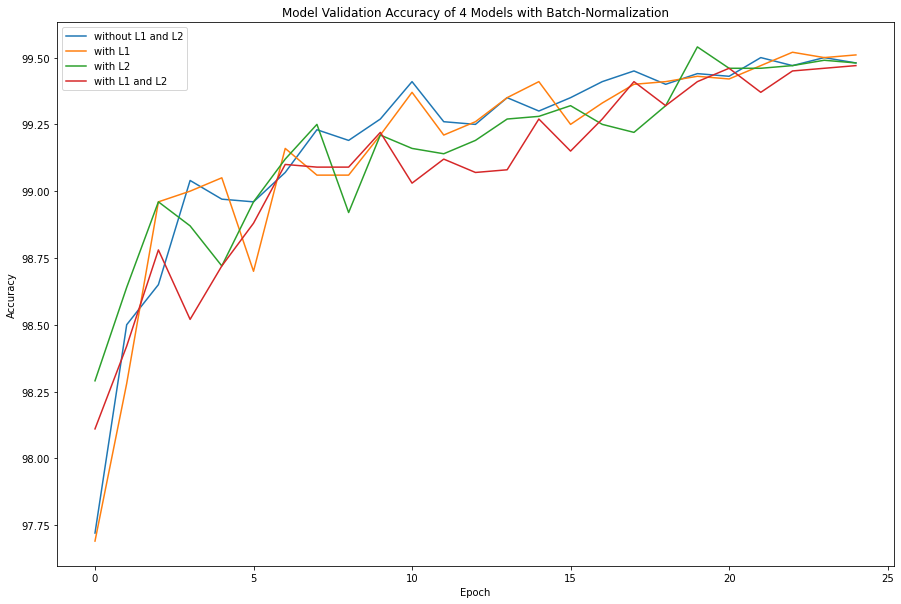

In [16]:

    # without L1/L2 with BN
    # without L1/L2 with GBN
    # with L1 with BN
    # with L1 with GBN
    # with L2 with BN
    # with L2 with GBN
    # with L1 and L2 with BN
    # with L1 and L2 with GBN

# Validation Accuracy 

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(acc1)
ax.plot(acc2)
ax.plot(acc3)
ax.plot(acc4)
ax.set(title="Model Validation Accuracy of 4 Models with Batch-Normalization", xlabel="Epoch", ylabel="Accuracy")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("Accuracyof4modelswithBN.png")
plt.show()



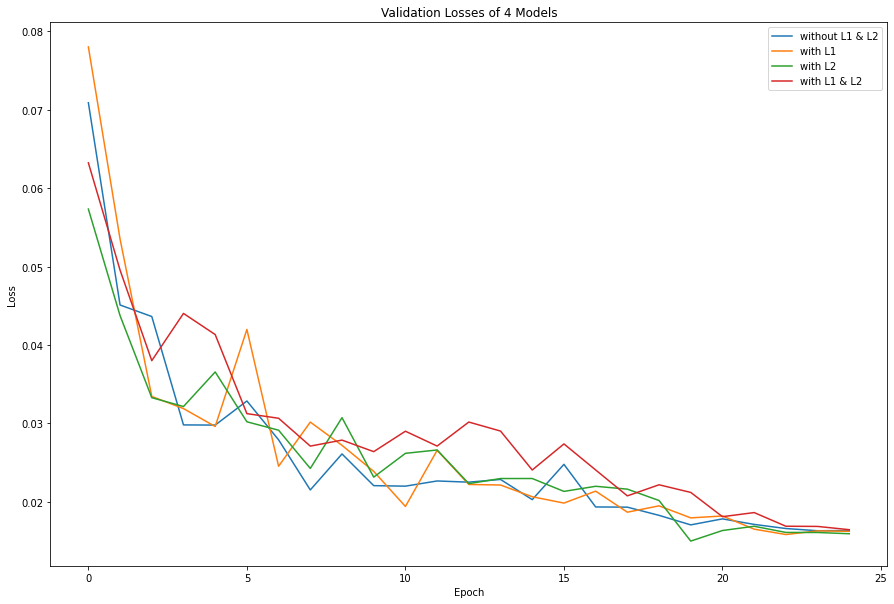

In [17]:
# Validation Loss 
plt.figure(figsize = (15,10))
ax = plt.subplot(111)
ax.plot(loss1)
ax.plot(loss2)
ax.plot(loss3)
ax.plot(loss4)
ax.set(title='Validation Losses of 4 Models', xlabel='Epoch', ylabel = 'Loss')
ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
plt.savefig('ValidationLossesBN.png')
plt.show()


In [0]:
# Misclassified Images
def misclassifiedOnes(model, filename):
  model = model.to(device)
  dataiter = iter(test_loader) 
  count = 0
  fig = plt.figure(figsize=(13,13))

  while count<25:
      images, labels = dataiter.next()
      images, labels = images.to(device), labels.to(device)
    
      output = model(images) 
      _, pred = torch.max(output, 1)   # convert output probabilities to predicted class
      images = images.cpu().numpy() # conv images to numpy format

      for idx in np.arange(128):
        if pred[idx]!=labels[idx]:
          ax = fig.add_subplot(5, 5, count+1, xticks=[], yticks=[])
          count=count+1
          ax.imshow(np.squeeze(images[idx]), cmap='cool')
          ax.set_title("Pred-{} (Target-{})".format(str(pred[idx].item()), str(labels[idx].item())), color="yellow")
          if count==25:
            break
      plt.savefig(filename)
   


Misclassifed Images from Model1
******************************


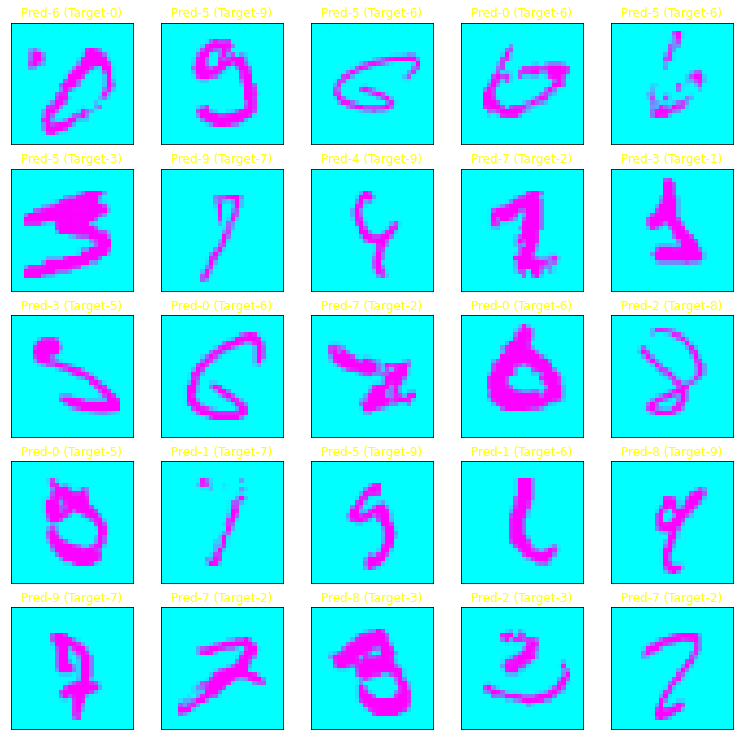

In [19]:
print('Misclassifed Images from Model1')
print('*'*30)

model.load_state_dict(torch.load("model1.pt")) 
misclassifiedOnes(model,'withoutL1_L2_BN.png')

Misclassifed Images from Model2
******************************


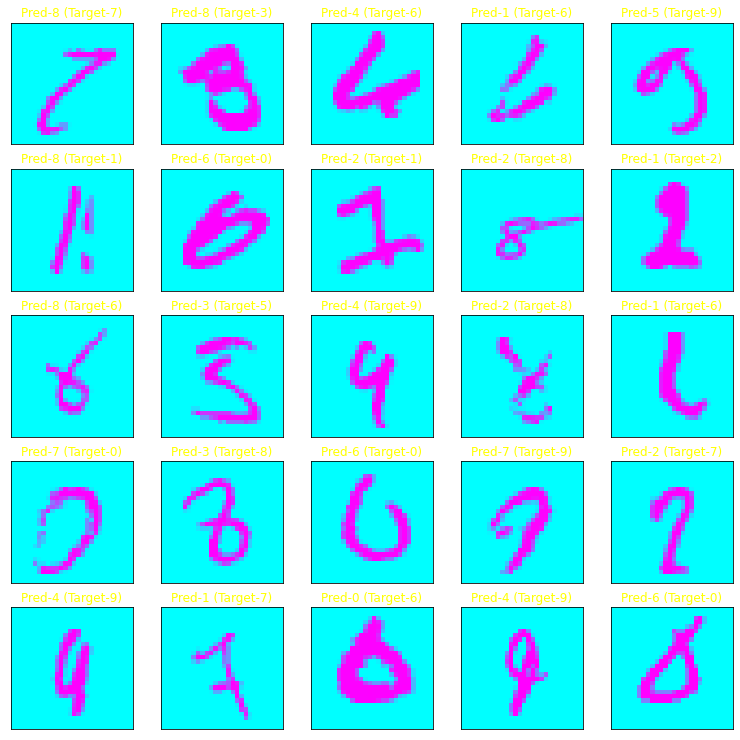

In [20]:
print('Misclassifed Images from Model2')
print('*'*30)

model.load_state_dict(torch.load("model2.pt")) 
misclassifiedOnes(model,'withL1_BN.png')

Misclassifed Images from Model3
******************************


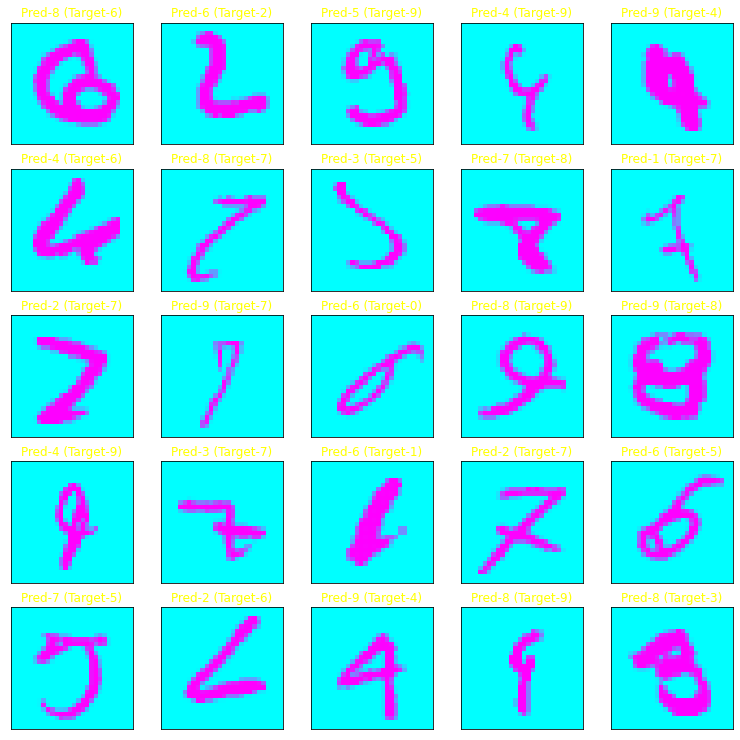

In [21]:
print('Misclassifed Images from Model3')
print('*'*30)
model.load_state_dict(torch.load("model3.pt")) 
misclassifiedOnes(model,'withL2_BN.png')

Misclassifed Images from Model4
******************************


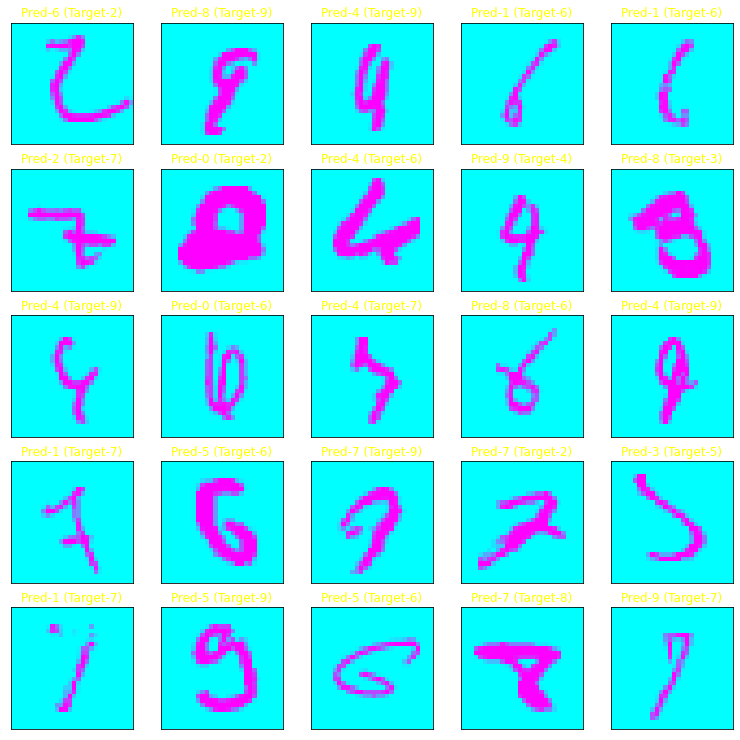

In [22]:
print('Misclassifed Images from Model4')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnes(model,'withL1_L2_BN.png')

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 64):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

In [0]:
# Main Model with Ghost Batch Normalization
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          GhostBatchNorm(8,2)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(10,2)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
          # nn.ReLU(),
          # nn.BatchNorm2d(16)) # O/P: 4


    # # ConvBlock 7
    #   self.convblock7 = nn.Sequential(
    #       nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False))
          # nn.ReLU(),
          # nn.BatchNorm2d(16)) # O/P: 4


    # # ConvBlock 8
    #   self.convblock8 = nn.Sequential(
    #       nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
    #       nn.ReLU(),
    #       nn.BatchNorm2d(16)) # O/P: 6
    

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      # x = self.drop(x)
      x = self.convblock6(x)
      # x = self.drop(x)
      # x = self.convblock7(x)
      # x = self.convblock8(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      


# Ghost Batch Normalization


class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0) # fill_() helps you filling up the tensor with a particular data
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)




In [50]:
# GBN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modelGBN = Net().to(device)
summary(modelGBN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
    GhostBatchNorm-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
   GhostBatchNorm-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None, L2lambda=None):
    modelGBN.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = modelGBN(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss


      # Implementing l2 Regularization
      if L2lambda:
        with torch.enable_grad():
          l2_loss = 0
          for name, param in model.named_parameters():
              l2_loss = l2_loss + (0.5 * l2_loss * torch.sum(torch.pow(W, 2)))
          loss = loss + L2Lambda * l2_loss


      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      modelGBN.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))

    # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
      self.valid_loss_min = test_loss

Model 5

In [0]:
# Model 5

def withoutL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  #scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with GBN')
#without L1 and L2 regularization with GBN

  model5= Test_Train()
  global loss5
  global acc5
  loss5 = model5.test_losses
  acc5 = model5.test_acc

  EPOCHS = 25  
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model5.train(model, device, train_loader, optimizer, epoch, scheduler)
      model5.test(model, device, test_loader,"model5.pt")



Model 6

In [0]:
# Model 6
from torch.optim.lr_scheduler import OneCycleLR

def withL1_GBN():
  model =  Net().to(device)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#sixth model
  print('with L1 regularization with GBN')
#with L1 regularization with BN
  model6 = Test_Train()
  global loss6
  global acc6
  loss6 = model6.test_losses
  acc6 = model6.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model6.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model6.test(model, device, test_loader,"model6.pt")

Model 7

In [0]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR

def withL2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#seventh model
  print('with L2 regularization with GBN')
#with L2 regularization 
  model7 = Test_Train()
  global loss7
  global acc7
  loss7 = model7.test_losses
  acc7 = model7.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model7.train(model, device, train_loader, optimizer, epoch, scheduler)
      model7.test(model, device, test_loader,"model7.pt")

Model 8

In [0]:


def withL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#eighth  model
  print('with L1 & L2 regularization with GBN')
#with both L1 & L2 regularization with BN
  model8 = Test_Train()
  global loss8
  global acc8
  loss8 = model8.test_losses
  acc8 = model8.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model8.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model8.test(model, device, test_loader,"model8.pt")

In [58]:
modelTuple = iter(withoutL1_L2_GBN(),
  withL1_GBN())

print(modelTuple.__next__())

  0%|          | 0/938 [00:00<?, ?it/s]

without L1 and L2 regularization with GBN
EPOCH: 1


Loss=2.300203800201416 Batch_id=937 Accuracy=8.49: 100%|██████████| 938/938 [01:00<00:00, 15.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3080, Accuracy: 788/10000 (7.88%)

Validation loss has  decreased (inf --> 2.3080).  Saving model ...
EPOCH: 2


Loss=2.3132433891296387 Batch_id=937 Accuracy=8.35: 100%|██████████| 938/938 [01:02<00:00, 15.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3076, Accuracy: 798/10000 (7.98%)

Validation loss has  decreased (inf --> 2.3076).  Saving model ...
EPOCH: 3


Loss=2.288466691970825 Batch_id=937 Accuracy=8.39: 100%|██████████| 938/938 [01:00<00:00, 15.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3074, Accuracy: 795/10000 (7.95%)

Validation loss has  decreased (inf --> 2.3074).  Saving model ...
EPOCH: 4


Loss=2.3181402683258057 Batch_id=937 Accuracy=8.55: 100%|██████████| 938/938 [01:00<00:00, 15.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3075, Accuracy: 800/10000 (8.00%)

Validation loss has  decreased (inf --> 2.3075).  Saving model ...
EPOCH: 5


Loss=2.301658868789673 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [01:00<00:00, 15.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3087, Accuracy: 772/10000 (7.72%)

Validation loss has  decreased (inf --> 2.3087).  Saving model ...
EPOCH: 6


Loss=2.299327850341797 Batch_id=937 Accuracy=8.23: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3077, Accuracy: 807/10000 (8.07%)

Validation loss has  decreased (inf --> 2.3077).  Saving model ...
EPOCH: 7


Loss=2.2971584796905518 Batch_id=937 Accuracy=8.35: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3078, Accuracy: 755/10000 (7.55%)

Validation loss has  decreased (inf --> 2.3078).  Saving model ...
EPOCH: 8


Loss=2.325138807296753 Batch_id=937 Accuracy=8.36: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3089, Accuracy: 808/10000 (8.08%)

Validation loss has  decreased (inf --> 2.3089).  Saving model ...
EPOCH: 9


Loss=2.3313517570495605 Batch_id=937 Accuracy=8.52: 100%|██████████| 938/938 [00:58<00:00, 16.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3091, Accuracy: 765/10000 (7.65%)

Validation loss has  decreased (inf --> 2.3091).  Saving model ...
EPOCH: 10


Loss=2.3191981315612793 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [00:58<00:00, 15.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3085, Accuracy: 780/10000 (7.80%)

Validation loss has  decreased (inf --> 2.3085).  Saving model ...
EPOCH: 11


Loss=2.3283965587615967 Batch_id=937 Accuracy=8.43: 100%|██████████| 938/938 [01:00<00:00, 15.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3097, Accuracy: 795/10000 (7.95%)

Validation loss has  decreased (inf --> 2.3097).  Saving model ...
EPOCH: 12


Loss=2.2616307735443115 Batch_id=937 Accuracy=8.38: 100%|██████████| 938/938 [00:59<00:00, 15.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3080, Accuracy: 762/10000 (7.62%)

Validation loss has  decreased (inf --> 2.3080).  Saving model ...
EPOCH: 13


Loss=2.325197458267212 Batch_id=937 Accuracy=8.48: 100%|██████████| 938/938 [01:00<00:00, 15.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3091, Accuracy: 758/10000 (7.58%)

Validation loss has  decreased (inf --> 2.3091).  Saving model ...
EPOCH: 14


Loss=2.292621612548828 Batch_id=937 Accuracy=8.36: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3082, Accuracy: 748/10000 (7.48%)

Validation loss has  decreased (inf --> 2.3082).  Saving model ...
EPOCH: 15


Loss=2.324239730834961 Batch_id=937 Accuracy=8.67: 100%|██████████| 938/938 [00:59<00:00, 15.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3094, Accuracy: 837/10000 (8.37%)

Validation loss has  decreased (inf --> 2.3094).  Saving model ...
EPOCH: 16


Loss=2.262932538986206 Batch_id=937 Accuracy=8.29: 100%|██████████| 938/938 [01:00<00:00, 15.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3086, Accuracy: 761/10000 (7.61%)

Validation loss has  decreased (inf --> 2.3086).  Saving model ...
EPOCH: 17


Loss=2.3083438873291016 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [01:01<00:00, 15.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3073, Accuracy: 774/10000 (7.74%)

Validation loss has  decreased (inf --> 2.3073).  Saving model ...
EPOCH: 18


Loss=2.3154172897338867 Batch_id=937 Accuracy=8.39: 100%|██████████| 938/938 [01:01<00:00, 15.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3082, Accuracy: 749/10000 (7.49%)

Validation loss has  decreased (inf --> 2.3082).  Saving model ...
EPOCH: 19


Loss=2.2980926036834717 Batch_id=937 Accuracy=8.38: 100%|██████████| 938/938 [01:02<00:00, 15.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3079, Accuracy: 740/10000 (7.40%)

Validation loss has  decreased (inf --> 2.3079).  Saving model ...
EPOCH: 20


Loss=2.3031668663024902 Batch_id=937 Accuracy=8.46: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3082, Accuracy: 750/10000 (7.50%)

Validation loss has  decreased (inf --> 2.3082).  Saving model ...
EPOCH: 21


Loss=2.308906316757202 Batch_id=937 Accuracy=8.23: 100%|██████████| 938/938 [01:07<00:00, 13.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3073, Accuracy: 809/10000 (8.09%)

Validation loss has  decreased (inf --> 2.3073).  Saving model ...
EPOCH: 22


Loss=2.324078321456909 Batch_id=937 Accuracy=8.34: 100%|██████████| 938/938 [01:00<00:00, 15.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3073, Accuracy: 806/10000 (8.06%)

Validation loss has  decreased (inf --> 2.3073).  Saving model ...
EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3083, Accuracy: 801/10000 (8.01%)

Validation loss has  decreased (inf --> 2.3083).  Saving model ...
EPOCH: 24


Loss=2.288550853729248 Batch_id=937 Accuracy=8.54: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3082, Accuracy: 758/10000 (7.58%)

Validation loss has  decreased (inf --> 2.3082).  Saving model ...
EPOCH: 25


Loss=2.308748960494995 Batch_id=937 Accuracy=8.53: 100%|██████████| 938/938 [00:58<00:00, 15.91it/s]



Test set: Average loss: 2.3085, Accuracy: 761/10000 (7.61%)

Validation loss has  decreased (inf --> 2.3085).  Saving model ...


  0%|          | 0/938 [00:00<?, ?it/s]

with L1 regularization with GBN
EPOCH: 1


Loss=2.3427724838256836 Batch_id=937 Accuracy=8.43: 100%|██████████| 938/938 [01:01<00:00, 15.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2991, Accuracy: 1114/10000 (11.14%)

Validation loss has  decreased (inf --> 2.2991).  Saving model ...
EPOCH: 2


Loss=2.310391664505005 Batch_id=937 Accuracy=8.43: 100%|██████████| 938/938 [01:01<00:00, 15.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2982, Accuracy: 1152/10000 (11.52%)

Validation loss has  decreased (inf --> 2.2982).  Saving model ...
EPOCH: 3


Loss=2.3006255626678467 Batch_id=937 Accuracy=8.37: 100%|██████████| 938/938 [01:02<00:00, 15.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2981, Accuracy: 1158/10000 (11.58%)

Validation loss has  decreased (inf --> 2.2981).  Saving model ...
EPOCH: 4


Loss=2.3050649166107178 Batch_id=937 Accuracy=8.50: 100%|██████████| 938/938 [01:00<00:00, 15.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2983, Accuracy: 1161/10000 (11.61%)

Validation loss has  decreased (inf --> 2.2983).  Saving model ...
EPOCH: 5


Loss=2.321842670440674 Batch_id=937 Accuracy=8.48: 100%|██████████| 938/938 [01:03<00:00, 14.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2979, Accuracy: 1231/10000 (12.31%)

Validation loss has  decreased (inf --> 2.2979).  Saving model ...
EPOCH: 6


Loss=2.3467419147491455 Batch_id=937 Accuracy=8.38: 100%|██████████| 938/938 [00:59<00:00, 15.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2976, Accuracy: 1230/10000 (12.30%)

Validation loss has  decreased (inf --> 2.2976).  Saving model ...
EPOCH: 7


Loss=2.3020071983337402 Batch_id=937 Accuracy=8.40: 100%|██████████| 938/938 [00:59<00:00, 15.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2998, Accuracy: 1195/10000 (11.95%)

Validation loss has  decreased (inf --> 2.2998).  Saving model ...
EPOCH: 8


Loss=2.3062803745269775 Batch_id=937 Accuracy=8.51: 100%|██████████| 938/938 [00:59<00:00, 15.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3013, Accuracy: 1215/10000 (12.15%)

Validation loss has  decreased (inf --> 2.3013).  Saving model ...
EPOCH: 9


Loss=2.3015339374542236 Batch_id=937 Accuracy=8.52: 100%|██████████| 938/938 [01:00<00:00, 15.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3016, Accuracy: 1284/10000 (12.84%)

Validation loss has  decreased (inf --> 2.3016).  Saving model ...
EPOCH: 10


Loss=2.331306219100952 Batch_id=937 Accuracy=8.28: 100%|██████████| 938/938 [00:59<00:00, 15.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 1262/10000 (12.62%)

Validation loss has  decreased (inf --> 2.3023).  Saving model ...
EPOCH: 11


Loss=2.320258617401123 Batch_id=937 Accuracy=8.33: 100%|██████████| 938/938 [00:58<00:00, 15.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3021, Accuracy: 1279/10000 (12.79%)

Validation loss has  decreased (inf --> 2.3021).  Saving model ...
EPOCH: 12


Loss=2.285508394241333 Batch_id=937 Accuracy=8.36: 100%|██████████| 938/938 [00:58<00:00, 15.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3020, Accuracy: 1253/10000 (12.53%)

Validation loss has  decreased (inf --> 2.3020).  Saving model ...
EPOCH: 13


Loss=2.321930170059204 Batch_id=937 Accuracy=8.53: 100%|██████████| 938/938 [00:57<00:00, 16.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3024, Accuracy: 1144/10000 (11.44%)

Validation loss has  decreased (inf --> 2.3024).  Saving model ...
EPOCH: 14


Loss=2.3120312690734863 Batch_id=937 Accuracy=8.37: 100%|██████████| 938/938 [00:56<00:00, 16.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1108/10000 (11.08%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 15


Loss=2.297488212585449 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [00:59<00:00, 15.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1113/10000 (11.13%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 16


Loss=2.315142869949341 Batch_id=937 Accuracy=8.40: 100%|██████████| 938/938 [00:56<00:00, 16.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1174/10000 (11.74%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 17


Loss=2.304015874862671 Batch_id=937 Accuracy=8.48: 100%|██████████| 938/938 [00:56<00:00, 16.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 18


Loss=2.2845876216888428 Batch_id=937 Accuracy=8.35: 100%|██████████| 938/938 [00:54<00:00, 17.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 19


Loss=2.3200862407684326 Batch_id=937 Accuracy=8.21: 100%|██████████| 938/938 [00:54<00:00, 17.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 20


Loss=2.298720359802246 Batch_id=937 Accuracy=8.28: 100%|██████████| 938/938 [00:55<00:00, 17.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 21


Loss=2.315274477005005 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [00:55<00:00, 17.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 22


Loss=2.3135533332824707 Batch_id=937 Accuracy=8.48: 100%|██████████| 938/938 [00:54<00:00, 17.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 24


Loss=2.2970058917999268 Batch_id=937 Accuracy=8.54: 100%|██████████| 938/938 [00:56<00:00, 16.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 25


Loss=2.310227155685425 Batch_id=937 Accuracy=8.24: 100%|██████████| 938/938 [00:58<00:00, 15.98it/s]



Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...


TypeError: ignored

In [59]:
modelTuple = iter(
  withL2_GBN(),
  withL1_L2_GBN())

print(modelTuple.__next__())

  0%|          | 0/938 [00:00<?, ?it/s]

with L2 regularization with GBN
EPOCH: 1


Loss=2.2979471683502197 Batch_id=937 Accuracy=8.33: 100%|██████████| 938/938 [00:55<00:00, 17.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2997, Accuracy: 979/10000 (9.79%)

Validation loss has  decreased (inf --> 2.2997).  Saving model ...
EPOCH: 2


Loss=2.2477540969848633 Batch_id=937 Accuracy=8.26: 100%|██████████| 938/938 [00:55<00:00, 16.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3002, Accuracy: 1012/10000 (10.12%)

Validation loss has  decreased (inf --> 2.3002).  Saving model ...
EPOCH: 3


Loss=2.3066658973693848 Batch_id=937 Accuracy=8.48: 100%|██████████| 938/938 [00:55<00:00, 16.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2989, Accuracy: 1026/10000 (10.26%)

Validation loss has  decreased (inf --> 2.2989).  Saving model ...
EPOCH: 4


Loss=2.322955369949341 Batch_id=937 Accuracy=8.42: 100%|██████████| 938/938 [00:54<00:00, 17.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2995, Accuracy: 1024/10000 (10.24%)

Validation loss has  decreased (inf --> 2.2995).  Saving model ...
EPOCH: 5


Loss=2.2911345958709717 Batch_id=937 Accuracy=8.37: 100%|██████████| 938/938 [00:55<00:00, 16.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2996, Accuracy: 1026/10000 (10.26%)

Validation loss has  decreased (inf --> 2.2996).  Saving model ...
EPOCH: 6


Loss=2.295785903930664 Batch_id=937 Accuracy=8.46: 100%|██████████| 938/938 [00:57<00:00, 16.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2999, Accuracy: 1033/10000 (10.33%)

Validation loss has  decreased (inf --> 2.2999).  Saving model ...
EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2995, Accuracy: 1039/10000 (10.39%)

Validation loss has  decreased (inf --> 2.2995).  Saving model ...
EPOCH: 8


Loss=2.3050758838653564 Batch_id=937 Accuracy=8.30: 100%|██████████| 938/938 [00:55<00:00, 16.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3005, Accuracy: 991/10000 (9.91%)

Validation loss has  decreased (inf --> 2.3005).  Saving model ...
EPOCH: 9


Loss=2.356088876724243 Batch_id=937 Accuracy=8.46: 100%|██████████| 938/938 [00:58<00:00, 16.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2994, Accuracy: 990/10000 (9.90%)

Validation loss has  decreased (inf --> 2.2994).  Saving model ...
EPOCH: 10


Loss=2.296132802963257 Batch_id=937 Accuracy=8.24: 100%|██████████| 938/938 [00:56<00:00, 16.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2986, Accuracy: 1066/10000 (10.66%)

Validation loss has  decreased (inf --> 2.2986).  Saving model ...
EPOCH: 11


Loss=2.3011832237243652 Batch_id=937 Accuracy=8.57: 100%|██████████| 938/938 [00:56<00:00, 16.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3004, Accuracy: 1021/10000 (10.21%)

Validation loss has  decreased (inf --> 2.3004).  Saving model ...
EPOCH: 12


Loss=2.3155014514923096 Batch_id=937 Accuracy=8.26: 100%|██████████| 938/938 [00:55<00:00, 16.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2992, Accuracy: 1066/10000 (10.66%)

Validation loss has  decreased (inf --> 2.2992).  Saving model ...
EPOCH: 13


Loss=2.304076910018921 Batch_id=937 Accuracy=8.50: 100%|██████████| 938/938 [00:54<00:00, 17.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2995, Accuracy: 1011/10000 (10.11%)

Validation loss has  decreased (inf --> 2.2995).  Saving model ...
EPOCH: 14


Loss=2.318638563156128 Batch_id=937 Accuracy=8.41: 100%|██████████| 938/938 [00:55<00:00, 16.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3001, Accuracy: 988/10000 (9.88%)

Validation loss has  decreased (inf --> 2.3001).  Saving model ...
EPOCH: 15


Loss=2.3277759552001953 Batch_id=937 Accuracy=8.55: 100%|██████████| 938/938 [00:55<00:00, 17.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2997, Accuracy: 1057/10000 (10.57%)

Validation loss has  decreased (inf --> 2.2997).  Saving model ...
EPOCH: 16


Loss=2.3072280883789062 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [00:54<00:00, 17.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2996, Accuracy: 1074/10000 (10.74%)

Validation loss has  decreased (inf --> 2.2996).  Saving model ...
EPOCH: 17


Loss=2.307063102722168 Batch_id=937 Accuracy=8.27: 100%|██████████| 938/938 [00:53<00:00, 17.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2995, Accuracy: 1036/10000 (10.36%)

Validation loss has  decreased (inf --> 2.2995).  Saving model ...
EPOCH: 18


Loss=2.320854663848877 Batch_id=937 Accuracy=8.46: 100%|██████████| 938/938 [00:54<00:00, 17.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3000, Accuracy: 1011/10000 (10.11%)

Validation loss has  decreased (inf --> 2.3000).  Saving model ...
EPOCH: 19


Loss=2.2893426418304443 Batch_id=937 Accuracy=8.53: 100%|██████████| 938/938 [00:56<00:00, 16.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2999, Accuracy: 1050/10000 (10.50%)

Validation loss has  decreased (inf --> 2.2999).  Saving model ...
EPOCH: 20


Loss=2.3426506519317627 Batch_id=937 Accuracy=8.35: 100%|██████████| 938/938 [00:57<00:00, 16.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2996, Accuracy: 1060/10000 (10.60%)

Validation loss has  decreased (inf --> 2.2996).  Saving model ...
EPOCH: 21


Loss=2.294205904006958 Batch_id=937 Accuracy=8.34: 100%|██████████| 938/938 [00:57<00:00, 16.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2999, Accuracy: 1012/10000 (10.12%)

Validation loss has  decreased (inf --> 2.2999).  Saving model ...
EPOCH: 22


Loss=2.2971534729003906 Batch_id=937 Accuracy=8.34: 100%|██████████| 938/938 [00:57<00:00, 16.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3007, Accuracy: 1011/10000 (10.11%)

Validation loss has  decreased (inf --> 2.3007).  Saving model ...
EPOCH: 23


Loss=2.313164710998535 Batch_id=937 Accuracy=8.51: 100%|██████████| 938/938 [00:57<00:00, 16.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2993, Accuracy: 1037/10000 (10.37%)

Validation loss has  decreased (inf --> 2.2993).  Saving model ...
EPOCH: 24


Loss=2.3231680393218994 Batch_id=937 Accuracy=8.47: 100%|██████████| 938/938 [00:59<00:00, 15.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2994, Accuracy: 1063/10000 (10.63%)

Validation loss has  decreased (inf --> 2.2994).  Saving model ...
EPOCH: 25


Loss=2.3192319869995117 Batch_id=937 Accuracy=8.41: 100%|██████████| 938/938 [00:59<00:00, 15.79it/s]



Test set: Average loss: 2.2999, Accuracy: 1063/10000 (10.63%)

Validation loss has  decreased (inf --> 2.2999).  Saving model ...


  0%|          | 0/938 [00:00<?, ?it/s]

with L1 & L2 regularization with GBN
EPOCH: 1


Loss=2.3033595085144043 Batch_id=937 Accuracy=8.33: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3281, Accuracy: 582/10000 (5.82%)

Validation loss has  decreased (inf --> 2.3281).  Saving model ...
EPOCH: 2


Loss=2.302018880844116 Batch_id=937 Accuracy=8.26: 100%|██████████| 938/938 [01:01<00:00, 15.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3250, Accuracy: 574/10000 (5.74%)

Validation loss has  decreased (inf --> 2.3250).  Saving model ...
EPOCH: 3


Loss=2.3089404106140137 Batch_id=937 Accuracy=8.25: 100%|██████████| 938/938 [00:59<00:00, 15.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3197, Accuracy: 604/10000 (6.04%)

Validation loss has  decreased (inf --> 2.3197).  Saving model ...
EPOCH: 4


Loss=2.2980408668518066 Batch_id=937 Accuracy=8.41: 100%|██████████| 938/938 [00:59<00:00, 15.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3139, Accuracy: 625/10000 (6.25%)

Validation loss has  decreased (inf --> 2.3139).  Saving model ...
EPOCH: 5


Loss=2.3050663471221924 Batch_id=937 Accuracy=8.48: 100%|██████████| 938/938 [00:57<00:00, 16.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3092, Accuracy: 583/10000 (5.83%)

Validation loss has  decreased (inf --> 2.3092).  Saving model ...
EPOCH: 6


Loss=2.2920286655426025 Batch_id=937 Accuracy=8.56: 100%|██████████| 938/938 [00:57<00:00, 16.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3061, Accuracy: 606/10000 (6.06%)

Validation loss has  decreased (inf --> 2.3061).  Saving model ...
EPOCH: 7


Loss=2.2626795768737793 Batch_id=937 Accuracy=8.68: 100%|██████████| 938/938 [00:57<00:00, 16.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3039, Accuracy: 644/10000 (6.44%)

Validation loss has  decreased (inf --> 2.3039).  Saving model ...
EPOCH: 8


Loss=2.3424808979034424 Batch_id=937 Accuracy=8.37: 100%|██████████| 938/938 [00:57<00:00, 16.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3030, Accuracy: 683/10000 (6.83%)

Validation loss has  decreased (inf --> 2.3030).  Saving model ...
EPOCH: 9


Loss=2.3092339038848877 Batch_id=937 Accuracy=8.41: 100%|██████████| 938/938 [00:57<00:00, 16.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3024, Accuracy: 936/10000 (9.36%)

Validation loss has  decreased (inf --> 2.3024).  Saving model ...
EPOCH: 10


Loss=2.3034262657165527 Batch_id=937 Accuracy=8.48: 100%|██████████| 938/938 [00:55<00:00, 16.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3022, Accuracy: 1366/10000 (13.66%)

Validation loss has  decreased (inf --> 2.3022).  Saving model ...
EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1065/10000 (10.65%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 12


Loss=2.330475091934204 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [00:54<00:00, 17.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 802/10000 (8.02%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 13


Loss=2.269139051437378 Batch_id=937 Accuracy=8.53: 100%|██████████| 938/938 [00:55<00:00, 16.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 14


Loss=2.3328723907470703 Batch_id=937 Accuracy=8.48: 100%|██████████| 938/938 [00:54<00:00, 17.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 15


Loss=2.2982773780822754 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 16


Loss=2.3085405826568604 Batch_id=937 Accuracy=8.45: 100%|██████████| 938/938 [00:53<00:00, 17.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 17


Loss=2.3123812675476074 Batch_id=937 Accuracy=8.45: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 18


Loss=2.3060407638549805 Batch_id=937 Accuracy=8.35: 100%|██████████| 938/938 [00:52<00:00, 17.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 19


Loss=2.2664968967437744 Batch_id=937 Accuracy=8.52: 100%|██████████| 938/938 [00:52<00:00, 17.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 20


Loss=2.318099021911621 Batch_id=937 Accuracy=8.29: 100%|██████████| 938/938 [00:53<00:00, 17.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 21


Loss=2.302635669708252 Batch_id=937 Accuracy=8.57: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 22


Loss=2.3167965412139893 Batch_id=937 Accuracy=8.31: 100%|██████████| 938/938 [00:52<00:00, 17.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 23


Loss=2.3036208152770996 Batch_id=937 Accuracy=8.54: 100%|██████████| 938/938 [00:52<00:00, 17.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 24


Loss=2.3271520137786865 Batch_id=937 Accuracy=8.39: 100%|██████████| 938/938 [00:55<00:00, 16.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...
EPOCH: 25


Loss=2.3009579181671143 Batch_id=937 Accuracy=8.35: 100%|██████████| 938/938 [00:54<00:00, 17.27it/s]



Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Validation loss has  decreased (inf --> 2.3026).  Saving model ...


TypeError: ignored

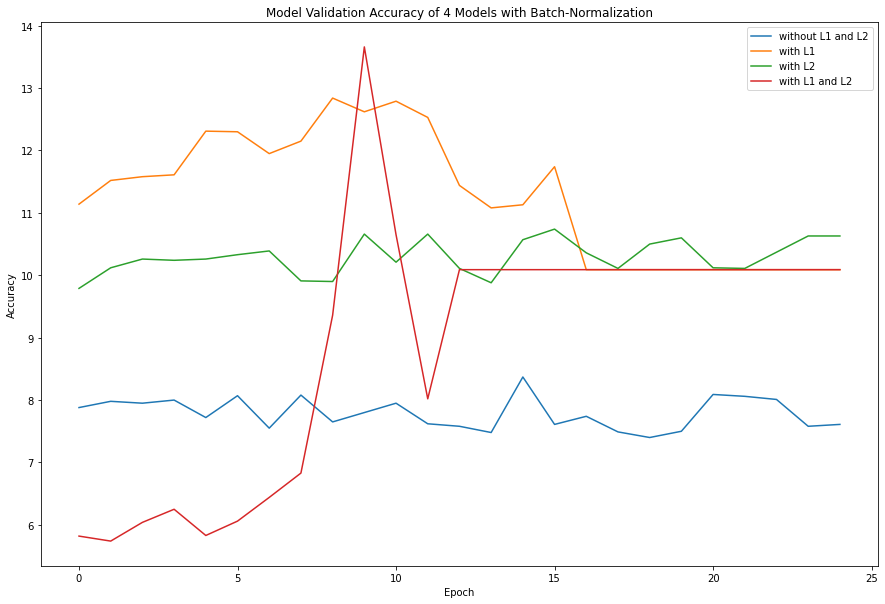

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(acc5)
ax.plot(acc6)
ax.plot(acc7)
ax.plot(acc8)
ax.set(title="Model Validation Accuracy of 4 Models with Batch-Normalization", xlabel="Epoch", ylabel="Accuracy")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("Accuracyof4modelswithBN.png")
plt.show()

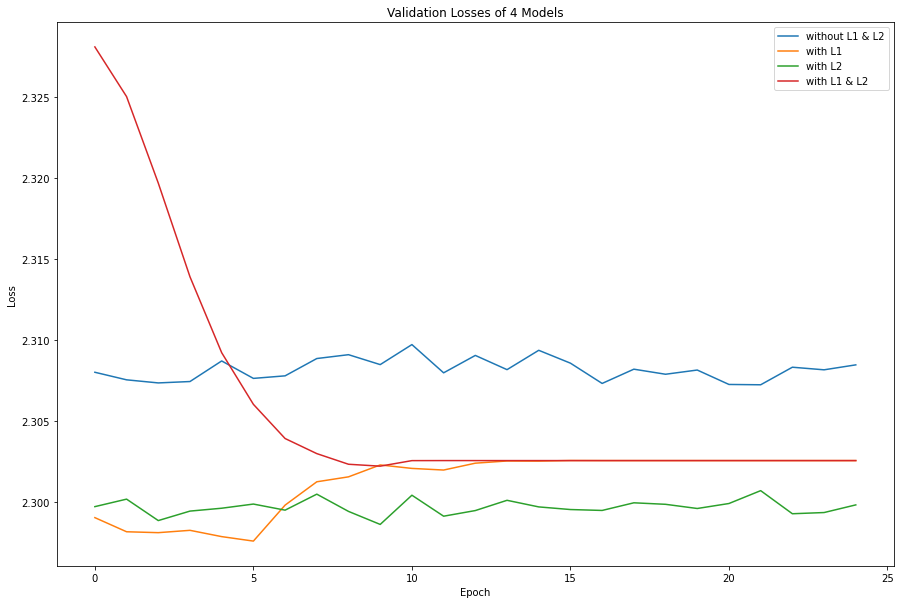

In [61]:
# Validation Loss 
plt.figure(figsize = (15,10))
ax = plt.subplot(111)
ax.plot(loss5)
ax.plot(loss6)
ax.plot(loss7)
ax.plot(loss8)
ax.set(title='Validation Losses of 4 Models', xlabel='Epoch', ylabel = 'Loss')
ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
plt.savefig('ValidationLossesBN.png')
plt.show()

In [0]:
def misclassifiedOnes1(model, filename):
  model = model.to(device)
  dataiter = iter(test_loader) 
  count = 0
  fig = plt.figure(figsize=(13,13))

  while count<25:
      images, labels = dataiter.next()
      images, labels = images.to(device), labels.to(device)
    
      output = model(images) 
      _, pred = torch.max(output, 1)   # convert output probabilities to predicted class
      images = images.cpu().numpy() # conv images to numpy format

      for idx in np.arange(64):
        if pred[idx]!=labels[idx]:
          ax = fig.add_subplot(5, 5, count+1, xticks=[], yticks=[])
          count=count+1
          ax.imshow(np.squeeze(images[idx]), cmap='cool')
          ax.set_title("Pred-{} (Target-{})".format(str(pred[idx].item()), str(labels[idx].item())), color="yellow")
          if count==25:
            break
      plt.savefig(filename)
   

In [65]:
print('Misclassifed Images from Model5')
print('*'*30)

model.load_state_dict(torch.load("model5.pt")) 
misclassifiedOnes1(model,'withoutL1_L2_GBN.png')

Misclassifed Images from Model5
******************************


RuntimeError: ignored

In [0]:
print('Misclassifed Images from Model6')
print('*'*30)

model.load_state_dict(torch.load("model5.pt")) 
misclassifiedOnes(model,'withL1_GBN.png')

In [0]:
print('Misclassifed Images from Model7')
print('*'*30)

model.load_state_dict(torch.load("model7.pt")) 
misclassifiedOnes(model,'withL2_GBN.png')

In [0]:
print('Misclassifed Images from Model8')
print('*'*30)

model.load_state_dict(torch.load("model8.pt")) 
misclassifiedOnes(model,'withL1_L2_GBN.png')